In [1]:
import os
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


Preparing training data for analysis

In [2]:
# Generate data paths with labels
train_data_dir = 'Desktop/COVID-19/archive/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df

,filepaths,labels
0,Desktop/COVID-19/archive/chest_xray/train\NORM...,NORMAL
1,Desktop/COVID-19/archive/chest_xray/train\NORM...,NORMAL
2,Desktop/COVID-19/archive/chest_xray/train\NORM...,NORMAL
3,Desktop/COVID-19/archive/chest_xray/train\NORM...,NORMAL
4,Desktop/COVID-19/archive/chest_xray/train\NORM...,NORMAL
...,...,...
5211,Desktop/COVID-19/archive/chest_xray/train\PNEU...,PNEUMONIA
5212,Desktop/COVID-19/archive/chest_xray/train\PNEU...,PNEUMONIA
5213,Desktop/COVID-19/archive/chest_xray/train\PNEU...,PNEUMONIA
5214,Desktop/COVID-19/archive/chest_xray/train\PNEU...,PNEUMONIA


Preparing test data for analysis

In [18]:
# Generate data paths with labels
test_data_dir = 'Desktop/COVID-19/archive/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

Preparing Validation Data for Analysis

In [19]:
# Generate data paths with labels
val_data_dir = 'Desktop/COVID-19/archive/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(val_data_dir)
for fold in folds:
    foldpath = os.path.join(val_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
valid_df = pd.concat([Fseries, Lseries], axis= 1)

Creating Data Generators for Training, Validation, and Testing

In [20]:
 #crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Displaying Sample Images from Training Data

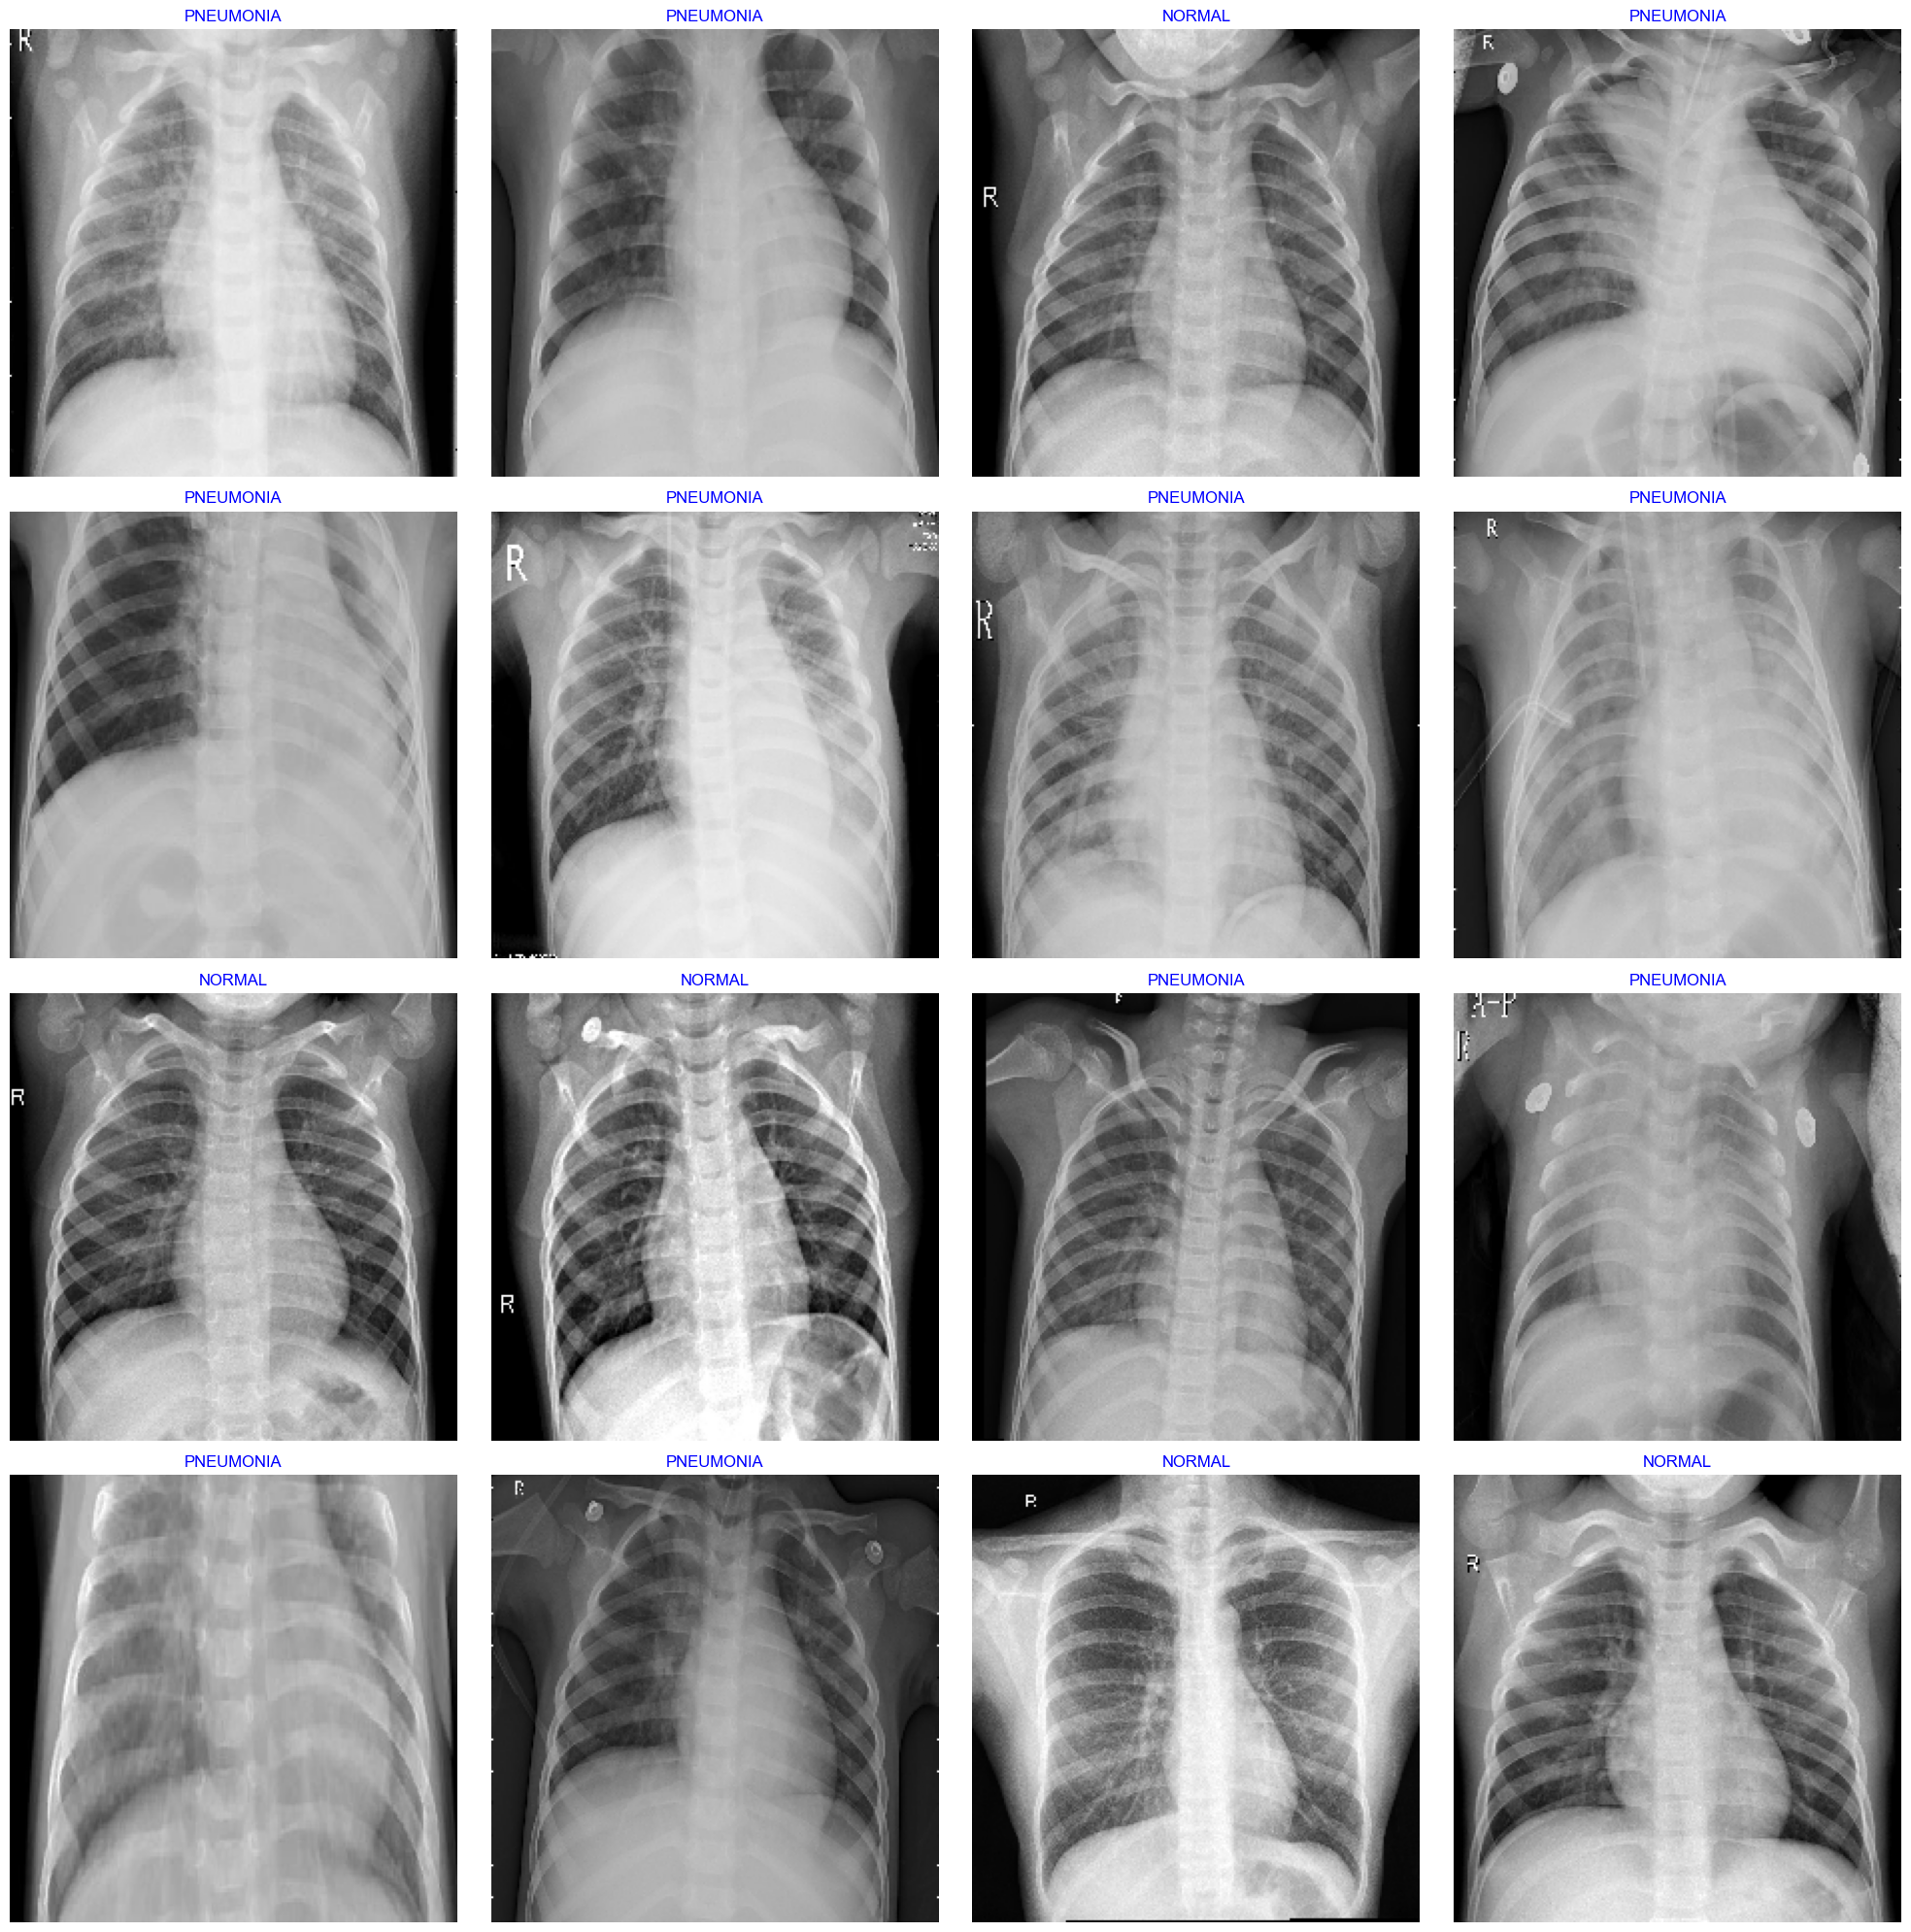

In [6]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

Defining Convolutional Neural Network (CNN) Architecture

In [7]:

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                 

Executing the Training Process

In [9]:
epochs = 2   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/2


326/326 [==============================] - 3226s 10s/step - loss: 1.7328 - accuracy: 0.8133 - val_loss: 0.6778 - val_accuracy: 0.7500
Epoch 2/2
326/326 [==============================] - 3137s 10s/step - loss: 0.1609 - accuracy: 0.9385 - val_loss: 0.6730 - val_accuracy: 0.7500


Plotting Training History

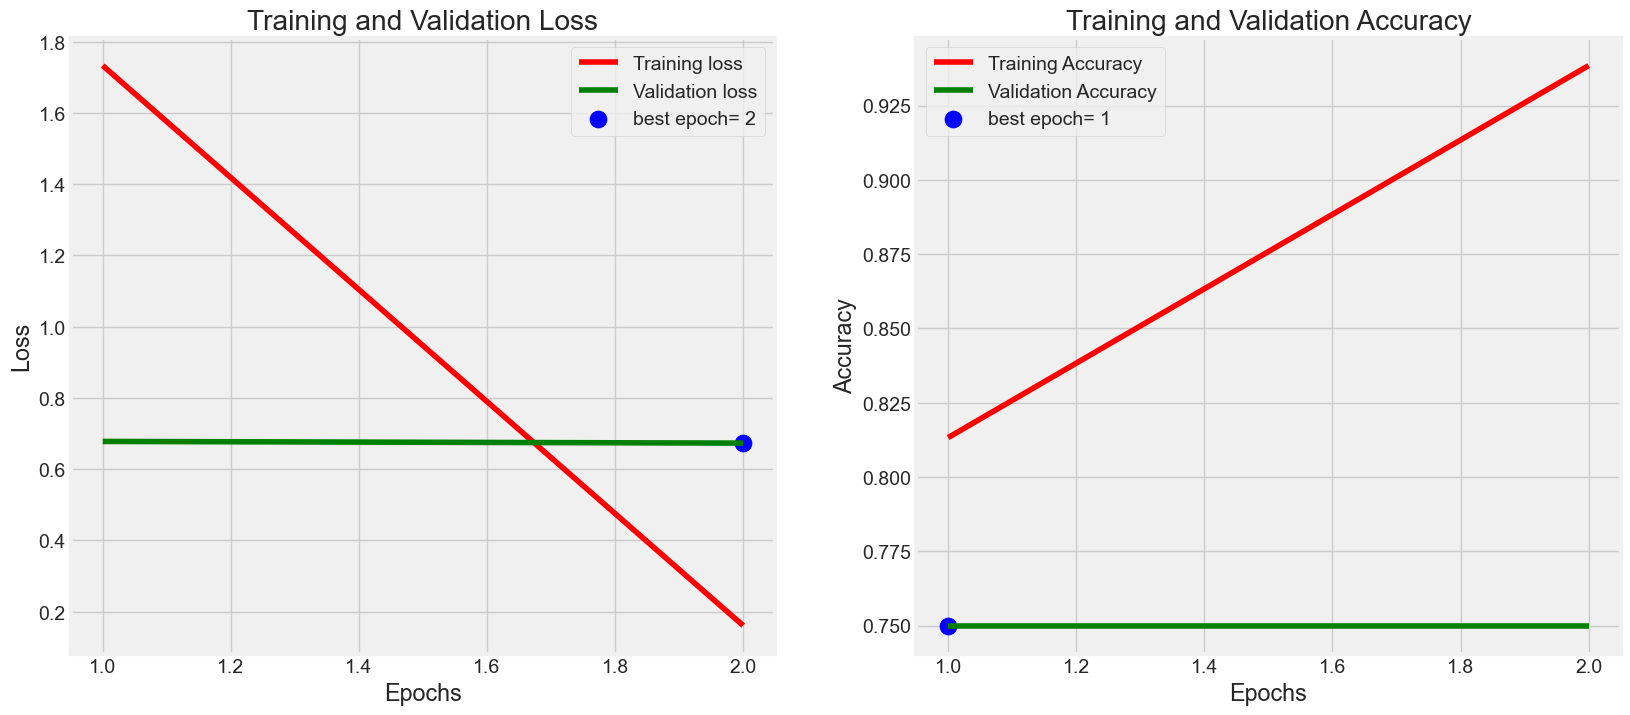

In [10]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Evaluating Model Performance

In [11]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

39/39 [==============================] - 80s 2s/step - loss: 0.7757 - accuracy: 0.8221
Train Loss:  0.0864940658211708
Train Accuracy:  0.9672162532806396
--------------------
Validation Loss:  0.6730131506919861
Validation Accuracy:  0.75
--------------------
Test Loss:  0.775726318359375
Test Accuracy:  0.8221153616905212


Generating Predictions

In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1) 

Confusion Matrix Visualization

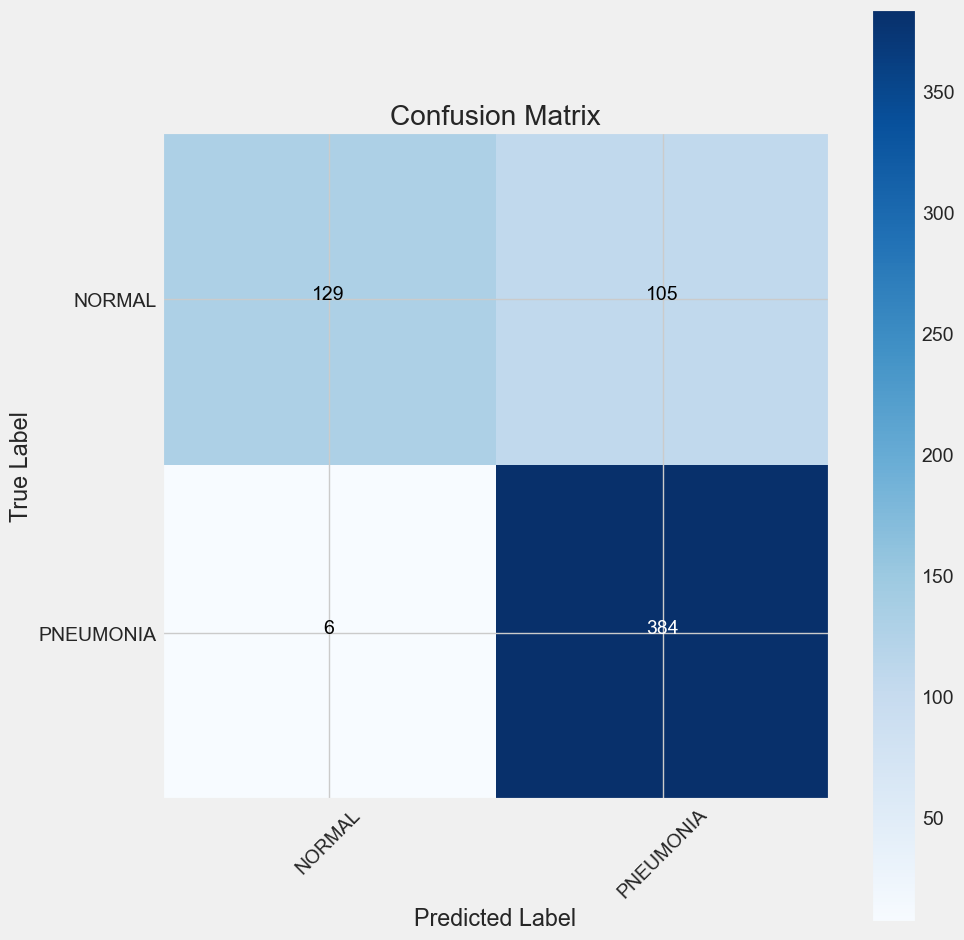

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Printing Classification Report

In [27]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.96      0.55      0.70       234
   PNEUMONIA       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



Saving the Model

In [28]:
model.save('Pneumonia.h5')

Loading and Compiling Model

In [30]:
loaded_model = tf.keras.models.load_model('Pneumonia.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


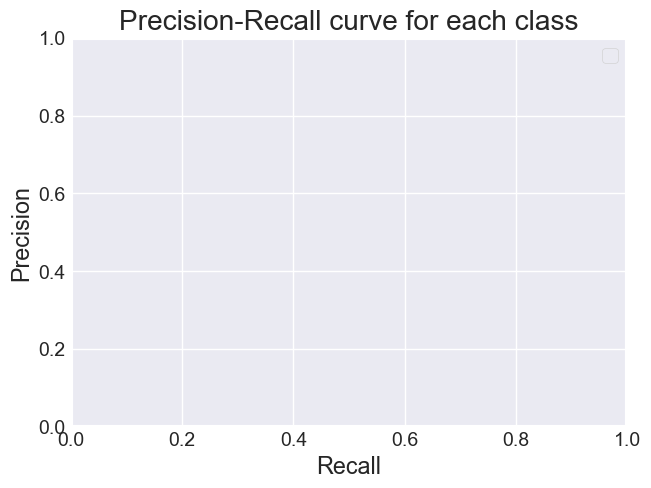

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

 
precision = dict()
recall = dict()
average_precision = dict()

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="best")
plt.show()